<div style="float:right; width:100px; text-align: center; margin: 10px;">
<img src="https://crypto-lake.com/assets/img/lake.png" alt="Lake"/>
</div>

# Fake volume detection

Detect fake trades that happen especially on altcoins on smaller exchanges. This cleans up the data for futher analysis or feature computation.

The exchanges usually claim its not them generating the fake trades: 'some market markers do it' and the exchange cannot do anything about it. Well, surely they don't want to, as the higher volumes help them to reach better volume compared to their competition.

We use [crypto-lake.com](https://crypto-lake.com/#data&utm_source=github&utm_medium=organic&utm_campaign=analysis-sharing&utm_term=fake-volume-detection) sample/free market data.

Quick links:
- [edit this notebook online](https://mybinder.org/v2/gh/crypto-lake/analysis-sharing/main?filepath=fake_volume_detection.ipynb) using Binder
- go to [github repo](https://github.com/crypto-lake/analysis-sharing/) and read about our analysis contest
- [follow our activity on twitter](https://twitter.com/intent/user?screen_name=crypto_lake_com)

In [51]:
import datetime

import pandas as pd
import cufflinks as cf
import plotly.io as pio

import lakeapi

# Access crypto-lake free data
lakeapi.use_sample_data(anonymous_access=True)
# Set up default cufflinks plot configuration 
cf.set_config_file(margin = (10,10,10,50), dimensions = (1000, 400))
# Comment for interactive plots. Doesn't work inside github/nbviewer
pio.renderers.default = "png"

In [52]:
# Parameters
symbol = 'AVAX-USDT'
exchange = 'GATEIO'
tick_size = 0.001

start = datetime.datetime(2022, 11, 2)
end = datetime.datetime(2022, 11, 10)

## Data

In [53]:
def load_data(table: str):
    print('Loading', table)
    return lakeapi.load_data(
        table = table,
        start = start,
        end = end,
        symbols = [symbol],
        exchanges = [exchange],
        drop_partition_cols = True,
    ).sort_values('received_time')

# Load l1 data = top of the order book
l1 = load_data('level_1')
l1 = l1.drop(columns = ['bid_0_size', 'ask_0_size'])
# Load trades
trades = load_data('trades')
trades = trades.drop(columns = ['trade_id', 'origin_time'])

Loading level_1


  0%|          | 0/8 [00:00<?, ?it/s]

Loading trades


  0%|          | 0/8 [00:00<?, ?it/s]

In [54]:
# Merge trades and l1 data
l1['future_bid'] = l1.bid_0_price.shift(-1)
l1['future_ask'] = l1.ask_0_price.shift(-1)


df = pd.merge_asof(
	left = trades.rename(columns = {'received_time': 'trade_received_time'}),
	right = l1.rename(columns = {'received_time': 'depth_received_time'}),
	left_on = 'trade_received_time',
	right_on = 'depth_received_time',
	tolerance = pd.Timedelta(minutes = 60),
)
df = df.dropna().reset_index(drop = True)
df['spread_ticks'] = (df.ask_0_price - df.bid_0_price) / tick_size
df['mid'] = (df.ask_0_price + df.bid_0_price) / 2
df['nominal'] = df.price * df.quantity
df.head(3)

,side,quantity,price,trade_received_time,depth_received_time,bid_0_price,ask_0_price,future_bid,future_ask,spread_ticks,mid,nominal
0,buy,0.2300,18.627,2022-11-02 00:00:08.830749952,2022-11-02 00:00:08.776986880,18.622,18.627,18.627,18.634,5.0,18.6245,4.284210
1,sell,53.1715,18.630,2022-11-02 00:00:11.768770048,2022-11-02 00:00:10.666189568,18.627,18.633,18.631,18.634,6.0,18.6300,990.585045
2,buy,0.1000,18.634,2022-11-02 00:00:14.085830400,2022-11-02 00:00:13.951588608,18.631,18.634,18.633,18.641,3.0,18.6325,1.863400


In [55]:
# Detection logic
epsilon = tick_size
df['fake'] = (
	# Trade is fake when its inside spread (+- some epsilon, perhaps one tick)
	(df['price'] > df['bid_0_price'] + epsilon) & 
	(df['price'] < df['ask_0_price'] - epsilon) &
	# To prevent false positives, we also assume we didn't receive the next depth update yet
	(df['price'] > df['future_bid'] + epsilon) & 
	(df['price'] < df['future_ask'] - epsilon)
)

fake_volume = df.loc[df['fake'] == 1, 'quantity'].sum()
all_volume = df['quantity'].sum()

# Note that this method has some false positives, but still leads to better & cleaner data for most use cases
print('Fake trade percentage', df['fake'].mean() * 100)
print('Fake volume percentage', fake_volume / all_volume * 100)

Fake trade percentage 9.352394730830731
Fake volume percentage 20.36472595150989


In [56]:
df.head(20)

,side,quantity,price,trade_received_time,depth_received_time,bid_0_price,ask_0_price,future_bid,future_ask,spread_ticks,mid,nominal,fake
0,buy,0.2300,18.627,2022-11-02 00:00:08.830749952,2022-11-02 00:00:08.776986880,18.622,18.627,18.627,18.634,5.0,18.6245,4.284210,False
1,sell,53.1715,18.630,2022-11-02 00:00:11.768770048,2022-11-02 00:00:10.666189568,18.627,18.633,18.631,18.634,6.0,18.6300,990.585045,False
2,buy,0.1000,18.634,2022-11-02 00:00:14.085830400,2022-11-02 00:00:13.951588608,18.631,18.634,18.633,18.641,3.0,18.6325,1.863400,False
3,buy,0.0249,18.634,2022-11-02 00:00:14.085894400,2022-11-02 00:00:13.951588608,18.631,18.634,18.633,18.641,3.0,18.6325,0.463987,False
4,sell,6.9175,18.637,2022-11-02 00:00:21.430516736,2022-11-02 00:00:17.962067968,18.634,18.641,18.634,18.638,7.0,18.6375,128.921447,False
5,sell,0.2457,18.634,2022-11-02 00:00:24.441881600,2022-11-02 00:00:24.263462656,18.634,18.638,18.627,18.634,4.0,18.6360,4.578374,False
6,sell,67.9033,18.634,2022-11-02 00:00:24.441948160,2022-11-02 00:00:24.263462656,18.634,18.638,18.627,18.634,4.0,18.6360,1265.310092,False
7,sell,0.1248,18.627,2022-11-02 00:00:28.731044352,2022-11-02 00:00:28.251558912,18.627,18.628,18.622,18.624,1.0,18.6275,2.324650,False
8,sell,0.2238,18.622,2022-11-02 00:00:31.640279040,2022-11-02 00:00:30.446400256,18.622,18.624,18.620,18.624,2.0,18.6230,4.167604,False
9,sell,0.1250,18.620,2022-11-02 00:00:32.594675712,2022-11-02 00:00:31.766279424,18.620,18.624,18.615,18.617,4.0,18.6220,2.327500,False


In [57]:
df[df.fake == 1][::5].head(10)

,side,quantity,price,trade_received_time,depth_received_time,bid_0_price,ask_0_price,future_bid,future_ask,spread_ticks,mid,nominal,fake
66,sell,5.5865,18.551,2022-11-02 00:04:47.432272896,2022-11-02 00:04:47.064792832,18.548,18.555,18.548,18.554,7.0,18.5515,103.635161,True
312,sell,41.3356,18.442,2022-11-02 00:09:25.140438528,2022-11-02 00:09:22.660326144,18.439,18.446,18.439,18.446,7.0,18.4425,762.311135,True
481,sell,6.0327,18.522,2022-11-02 00:17:34.859345664,2022-11-02 00:17:31.062978816,18.519,18.526,18.520,18.526,7.0,18.5225,111.737669,True
596,sell,8.6693,18.523,2022-11-02 00:26:07.234696960,2022-11-02 00:26:06.753536768,18.519,18.527,18.519,18.527,8.0,18.5230,160.581444,True
713,buy,0.4198,18.544,2022-11-02 00:38:30.987122432,2022-11-02 00:38:30.464579072,18.542,18.546,18.542,18.549,4.0,18.5440,7.784771,True
885,sell,6.6296,18.565,2022-11-02 00:54:31.892553728,2022-11-02 00:54:29.168528128,18.562,18.567,18.563,18.567,5.0,18.5645,123.078524,True
982,buy,0.3734,18.565,2022-11-02 01:11:32.952667392,2022-11-02 01:11:28.960417792,18.562,18.567,18.562,18.567,5.0,18.5645,6.932171,True
1135,sell,59.9736,18.542,2022-11-02 01:30:59.574305280,2022-11-02 01:30:54.980418560,18.538,18.544,18.538,18.544,6.0,18.5410,1112.030491,True
1176,buy,0.6150,18.484,2022-11-02 01:39:14.867210496,2022-11-02 01:39:09.552626944,18.482,18.487,18.482,18.486,5.0,18.4845,11.367660,True
1349,sell,40.9156,18.402,2022-11-02 02:02:30.083915264,2022-11-02 02:02:29.757173504,18.399,18.406,18.399,18.405,7.0,18.4025,752.928871,True


## Plots

Open the notebook in Binder to see the plots, Github sadly doesn't support Plotly plots.

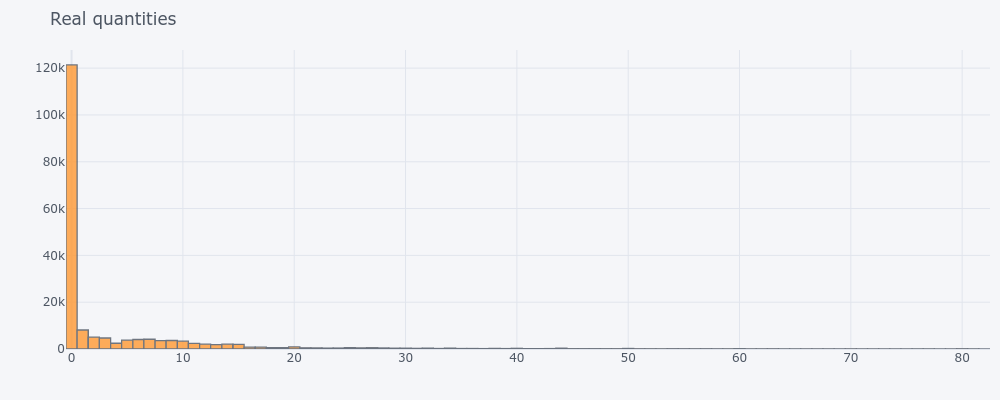

In [58]:
# How real trade quantities look like (drop outliers above 99% percentile for better visualisation)
df[(df.fake == 0) & (df.quantity < df.quantity.quantile(0.99))]['quantity'].iplot(kind = 'hist', bins = 100, title = 'Real quantities')

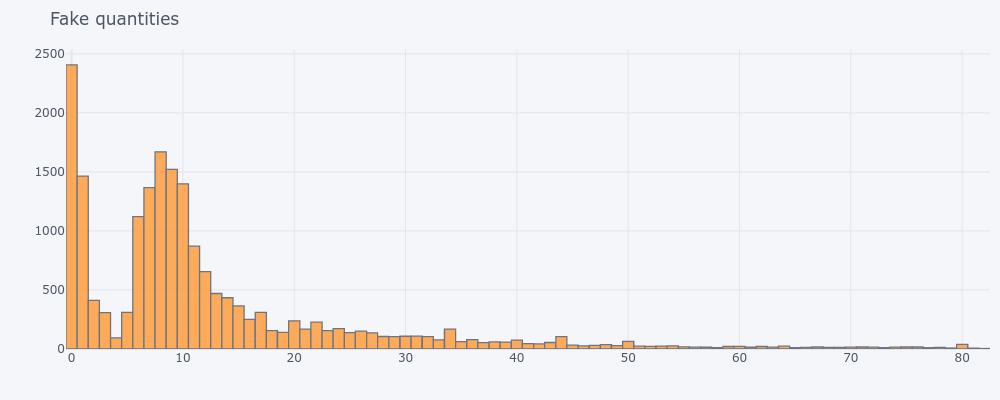

In [59]:
# How fake quantities look like, notice the block of trades with quantities 5-10. Perhaps the quantities are randomly sampled from normal distribution. 
# We could use this for even better detection with less false positives.
df[(df.fake == 1) & (df.quantity < df.quantity.quantile(0.99))]['quantity'].iplot(kind = 'hist', bins = 100, title = 'Fake quantities')

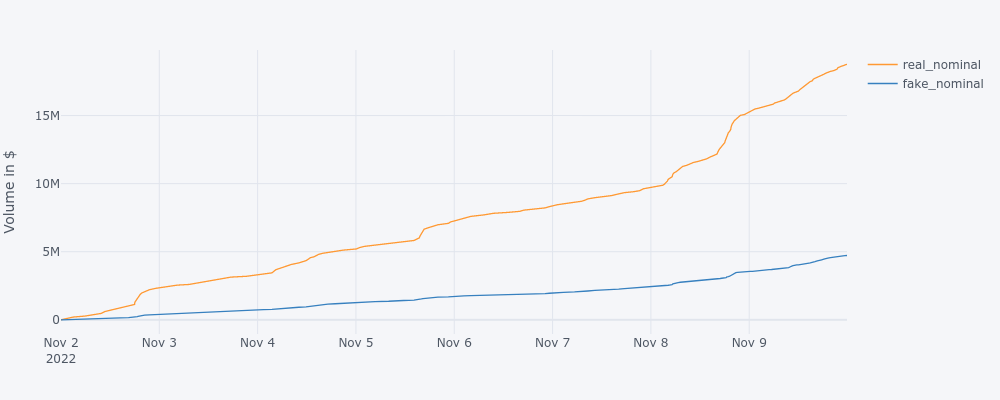

In [60]:
df['fake_nominal'] = df['nominal'] * df['fake']
df['real_nominal'] = df['nominal']  - df['fake_nominal']
df.set_index('trade_received_time')[['real_nominal', 'fake_nominal']].cumsum()[::1000].iplot(yTitle = 'Volume in $')
df = df.drop(columns = ['fake_nominal', 'real_nominal'])

## More data

What data are available in the crypto-lake anonymous sample repository. Uncomment to explore:

In [61]:
# for table in ('level_1', 'trades', 'book', 'candles'):
# 	available_data = pd.DataFrame(lakeapi.list_data(table = table))
# 	print(table)
# 	display(available_data[['exchange', 'symbol', 'dt']].groupby(['exchange', 'symbol']).aggregate({'dt': ['first', 'last']}))

## Conclusion

On the observed trading pair probably fake volume accounts for 10% of trades and 20% of volume. That is a lot and can hurt model precisions, especially during low volume periods, when most trades can be fake. It looks like the fake volume is pretty stable in time, doesn't follow volume as eg. VWAP or POV algos do. The fake trades appear to have quantity sampled from normal distribution with mean around 8.